In [1]:
# lstm autoencoder recreate sequence
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
import time
from sklearn.manifold import TSNE
import pandas

import seaborn as sns

In [3]:
def conv_angles(x,y,z,w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)

    X = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    index_out = np.where(np.absolute(t2)>=1)# get the index which is out of range
    sign_out = np.sign(t2) # if out of range change it to pi/2 or -pi/2
    t2[index_out] = t2[index_out] *sign_out[index_out] 
    Y = np.arcsin(t2)
    

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = np.arctan2(t3, t4)
    

    return X, Y, Z
    
def conv_euler_angles(X_pd): # input is the panda dataframe of X
    n_timestep, n_feature = 128, 10
    X_data_ori = X_pd.iloc[:,3:].values # original values
    n_example = int(np.shape(X_data_ori)[0]/n_timestep)

    new_feature= np.zeros((n_example, n_timestep, 3))
    X = np.reshape(X_data_ori, (n_example, n_timestep, n_feature))
    for id_n in range(n_example):
        x = X[id_n,:,0] # x
        y = X[id_n,:,1] # y
        z = X[id_n,:,2] # z
        w = X[id_n,:,3] # w
        
        new_feature[id_n,:,0], new_feature[id_n,:,1], new_feature[id_n,:,2] = conv_angles(x,y,z,w) 

        
    new_feature_norm_1d= np.reshape(new_feature,(n_example*n_timestep, 3))
    #new_feature_norm_1d = StandardScaler().fit_transform(new_feature_norm_1d)# standarlize the data
    
    new_feature_norm_2d = np.reshape(new_feature_norm_1d,(n_example, n_timestep, 3))
    X_values_comb = np.concatenate((X, new_feature_norm_2d), axis=2)

    return(X_values_comb)


In [4]:
def pre_data(file,n_timestep,n_features):
    X = pd.read_csv(file)
    X_data_comb = conv_euler_angles(X) # convert angels
     
    X['angle_X'] = X_data_comb[:,:,10].ravel()
    X['angle_Y'] = X_data_comb[:,:,11].ravel()
    X['angle_Z'] = X_data_comb[:,:,12].ravel()
    X_data = X.values[:,3:]
    X_data = StandardScaler().fit_transform(X_data) 
    X_data = MinMaxScaler().fit_transform(X_data) 
    n_examples = int(np.shape(X_data)[0]/n_timestep)
    
    X_data = np.reshape(X_data, (n_examples,n_timestep,n_features))
    
    print (np.shape(X_data))
    return (X_data)

In [5]:
file = 'Data/X_train.csv'
n_timestep = 128
n_features = 13

sequence = pre_data(file,n_timestep,n_features)


C:\Users\yizhe\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\yizhe\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(3810, 128, 13)


In [6]:
np.shape(sequence)

(3810, 128, 13)

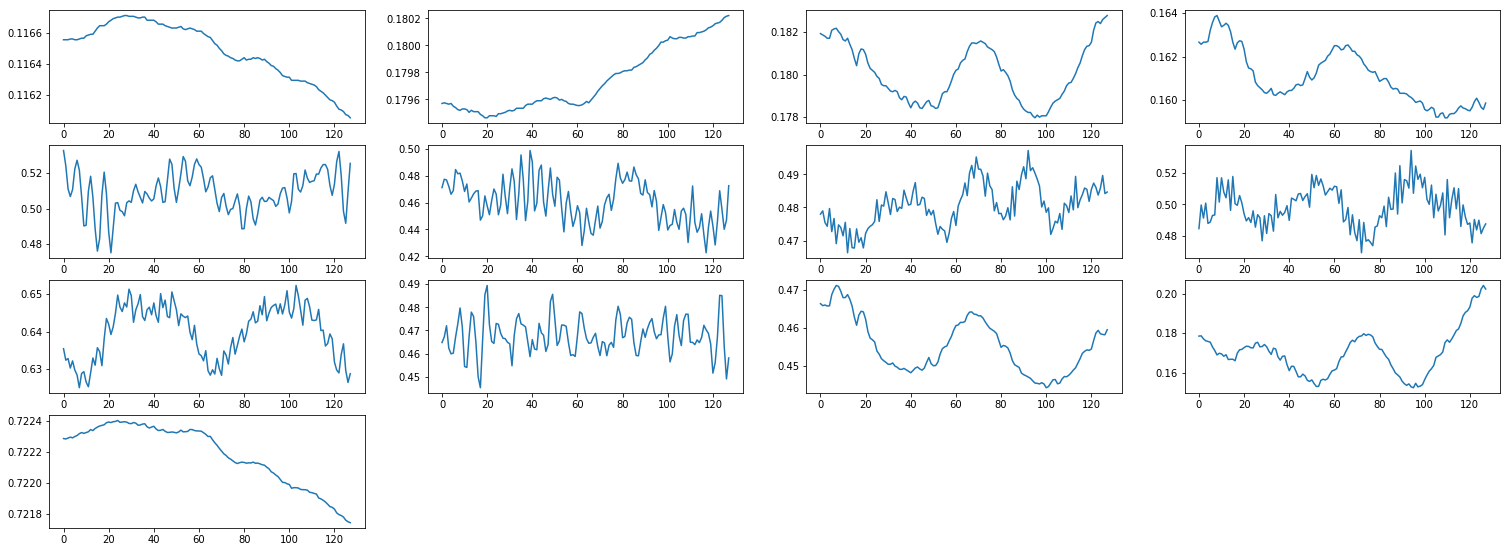

In [7]:
plt.figure (figsize =(26,12))
for col in range (13):
    plt.subplot(5, 4, col+1)
    plt.plot(sequence[0,:,col])

In [8]:
sequence = sequence[:,:,4:]
n_example, n_timestep,n_features = np.shape(sequence)

In [9]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_timestep,n_features)))
model.add(RepeatVector(n_timestep)) # repeat the same output for n_timestep times (upsampling)
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.add(Activation('tanh'))
model.summary()
optimizer_Adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_Adam, loss='mse', metrics=['accuracy'])
## try the lost of binary_crossentropy after normalize the data to 0-1
# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# if want to save whole model use h5
mc= ModelCheckpoint("weights_best.hdf5", monitor='val_acc', verbose=1, \
                    save_best_only=True, mode='max')

history = model.fit(sequence, sequence, epochs=2000, \
                    batch_size =1000, validation_split = 0.3, \
                    verbose=1, callbacks=[es, mc])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                12000     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 128, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 50)           20200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 9)            459       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 9)            0         
Total params: 32,659
Trainable params: 32,659
Non-trainable params: 0
_________________________________________________________________
Train on 2667 samples, validate on 1143 samples
Epoch 1/2000
2667/2667 [==============================] - 5s 2ms/step - loss: 0.2254 - acc

2667/2667 [==============================] - 2s 636us/step - loss: 0.0254 - acc: 0.6212 - val_loss: 0.0244 - val_acc: 0.5989

Epoch 00037: val_acc improved from 0.59589 to 0.59894, saving model to weights_best.hdf5
Epoch 38/2000
2667/2667 [==============================] - 2s 623us/step - loss: 0.0229 - acc: 0.6243 - val_loss: 0.0222 - val_acc: 0.6016

Epoch 00038: val_acc improved from 0.59894 to 0.60156, saving model to weights_best.hdf5
Epoch 39/2000
2667/2667 [==============================] - 2s 626us/step - loss: 0.0208 - acc: 0.6269 - val_loss: 0.0205 - val_acc: 0.6041

Epoch 00039: val_acc improved from 0.60156 to 0.60406, saving model to weights_best.hdf5
Epoch 40/2000
2667/2667 [==============================] - 2s 629us/step - loss: 0.0193 - acc: 0.6292 - val_loss: 0.0193 - val_acc: 0.6064

Epoch 00040: val_acc improved from 0.60406 to 0.60642, saving model to weights_best.hdf5
Epoch 41/2000
2667/2667 [==============================] - 2s 614us/step - loss: 0.0182 - acc: 0.6

2667/2667 [==============================] - 2s 632us/step - loss: 0.0105 - acc: 0.7935 - val_loss: 0.0113 - val_acc: 0.6859

Epoch 00075: val_acc improved from 0.67587 to 0.68590, saving model to weights_best.hdf5
Epoch 76/2000
2667/2667 [==============================] - 2s 625us/step - loss: 0.0103 - acc: 0.8080 - val_loss: 0.0111 - val_acc: 0.7034

Epoch 00076: val_acc improved from 0.68590 to 0.70341, saving model to weights_best.hdf5
Epoch 77/2000
2667/2667 [==============================] - 2s 618us/step - loss: 0.0101 - acc: 0.8225 - val_loss: 0.0109 - val_acc: 0.7172

Epoch 00077: val_acc improved from 0.70341 to 0.71723, saving model to weights_best.hdf5
Epoch 78/2000
2667/2667 [==============================] - 2s 625us/step - loss: 0.0100 - acc: 0.8382 - val_loss: 0.0108 - val_acc: 0.7296

Epoch 00078: val_acc improved from 0.71723 to 0.72963, saving model to weights_best.hdf5
Epoch 79/2000
2667/2667 [==============================] - 2s 654us/step - loss: 0.0098 - acc: 0.8

2667/2667 [==============================] - 2s 621us/step - loss: 0.0054 - acc: 0.9073 - val_loss: 0.0063 - val_acc: 0.8251

Epoch 00114: val_acc did not improve from 0.82657
Epoch 115/2000
2667/2667 [==============================] - 2s 624us/step - loss: 0.0054 - acc: 0.9084 - val_loss: 0.0062 - val_acc: 0.8263

Epoch 00115: val_acc did not improve from 0.82657
Epoch 116/2000
2667/2667 [==============================] - 2s 624us/step - loss: 0.0053 - acc: 0.9082 - val_loss: 0.0061 - val_acc: 0.8286

Epoch 00116: val_acc improved from 0.82657 to 0.82864, saving model to weights_best.hdf5
Epoch 117/2000
2667/2667 [==============================] - 2s 628us/step - loss: 0.0052 - acc: 0.9085 - val_loss: 0.0060 - val_acc: 0.8299

Epoch 00117: val_acc improved from 0.82864 to 0.82985, saving model to weights_best.hdf5
Epoch 118/2000
2667/2667 [==============================] - 2s 618us/step - loss: 0.0052 - acc: 0.9085 - val_loss: 0.0059 - val_acc: 0.8299

Epoch 00118: val_acc improved fr


Epoch 00150: val_acc improved from 0.90119 to 0.90124, saving model to weights_best.hdf5
Epoch 151/2000
2667/2667 [==============================] - 2s 629us/step - loss: 0.0034 - acc: 0.9349 - val_loss: 0.0035 - val_acc: 0.9005

Epoch 00151: val_acc did not improve from 0.90124
Epoch 152/2000
2667/2667 [==============================] - 2s 628us/step - loss: 0.0034 - acc: 0.9366 - val_loss: 0.0035 - val_acc: 0.9045

Epoch 00152: val_acc improved from 0.90124 to 0.90445, saving model to weights_best.hdf5
Epoch 153/2000
2667/2667 [==============================] - 2s 619us/step - loss: 0.0033 - acc: 0.9376 - val_loss: 0.0034 - val_acc: 0.9013

Epoch 00153: val_acc did not improve from 0.90445
Epoch 154/2000
2667/2667 [==============================] - 2s 627us/step - loss: 0.0033 - acc: 0.9373 - val_loss: 0.0034 - val_acc: 0.9034

Epoch 00154: val_acc did not improve from 0.90445
Epoch 155/2000
2667/2667 [==============================] - 2s 617us/step - loss: 0.0033 - acc: 0.9372 - va

2667/2667 [==============================] - 2s 617us/step - loss: 0.0025 - acc: 0.9524 - val_loss: 0.0025 - val_acc: 0.9172

Epoch 00191: val_acc did not improve from 0.91874
Epoch 192/2000
2667/2667 [==============================] - 2s 647us/step - loss: 0.0025 - acc: 0.9573 - val_loss: 0.0025 - val_acc: 0.9163

Epoch 00192: val_acc did not improve from 0.91874
Epoch 193/2000
2667/2667 [==============================] - 2s 628us/step - loss: 0.0025 - acc: 0.9556 - val_loss: 0.0024 - val_acc: 0.9181

Epoch 00193: val_acc did not improve from 0.91874
Epoch 194/2000
2667/2667 [==============================] - 2s 616us/step - loss: 0.0024 - acc: 0.9597 - val_loss: 0.0024 - val_acc: 0.9164

Epoch 00194: val_acc did not improve from 0.91874
Epoch 195/2000
2667/2667 [==============================] - 2s 649us/step - loss: 0.0024 - acc: 0.9583 - val_loss: 0.0024 - val_acc: 0.9196

Epoch 00195: val_acc improved from 0.91874 to 0.91961, saving model to weights_best.hdf5
Epoch 196/2000
2667/2

2667/2667 [==============================] - 2s 636us/step - loss: 0.0019 - acc: 0.9658 - val_loss: 0.0019 - val_acc: 0.9349

Epoch 00232: val_acc improved from 0.93461 to 0.93486, saving model to weights_best.hdf5
Epoch 233/2000
2667/2667 [==============================] - 2s 624us/step - loss: 0.0019 - acc: 0.9621 - val_loss: 0.0019 - val_acc: 0.9289

Epoch 00233: val_acc did not improve from 0.93486
Epoch 234/2000
2667/2667 [==============================] - 2s 623us/step - loss: 0.0019 - acc: 0.9637 - val_loss: 0.0019 - val_acc: 0.9354

Epoch 00234: val_acc improved from 0.93486 to 0.93539, saving model to weights_best.hdf5
Epoch 235/2000
2667/2667 [==============================] - 2s 629us/step - loss: 0.0020 - acc: 0.9638 - val_loss: 0.0019 - val_acc: 0.9358

Epoch 00235: val_acc improved from 0.93539 to 0.93582, saving model to weights_best.hdf5
Epoch 236/2000
2667/2667 [==============================] - 2s 634us/step - loss: 0.0020 - acc: 0.9658 - val_loss: 0.0020 - val_acc: 0

2667/2667 [==============================] - 2s 632us/step - loss: 0.0026 - acc: 0.9547 - val_loss: 0.0025 - val_acc: 0.9116

Epoch 00273: val_acc did not improve from 0.94332
Epoch 274/2000
2667/2667 [==============================] - 2s 631us/step - loss: 0.0025 - acc: 0.9546 - val_loss: 0.0024 - val_acc: 0.9073

Epoch 00274: val_acc did not improve from 0.94332
Epoch 275/2000
2667/2667 [==============================] - 2s 638us/step - loss: 0.0024 - acc: 0.9469 - val_loss: 0.0024 - val_acc: 0.9013

Epoch 00275: val_acc did not improve from 0.94332
Epoch 276/2000
2667/2667 [==============================] - 2s 637us/step - loss: 0.0023 - acc: 0.9414 - val_loss: 0.0023 - val_acc: 0.9012

Epoch 00276: val_acc did not improve from 0.94332
Epoch 277/2000
2667/2667 [==============================] - 2s 635us/step - loss: 0.0023 - acc: 0.9428 - val_loss: 0.0023 - val_acc: 0.9059

Epoch 00277: val_acc did not improve from 0.94332
Epoch 278/2000
2667/2667 [==============================] - 

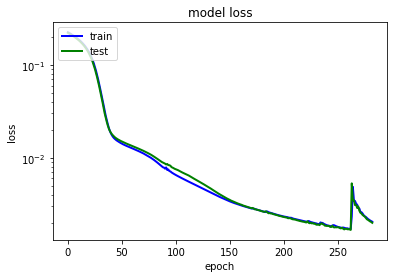

In [10]:
# summarize history for loss
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
line1, = ax.plot(history.history['loss'], color='blue', lw=2)
line, = ax.plot(history.history['val_loss'], color='green', lw=2)

ax.set_yscale('log')
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')

In [11]:
model.load_weights("weights_best.hdf5")

In [12]:
np.shape(sequence)

(3810, 128, 9)

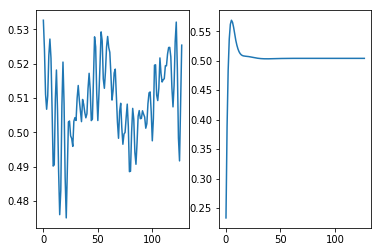

In [13]:
test_ex = sequence[0,:,:]
test_ex = np.expand_dims(test_ex, axis = 0)
y_pred = model.predict(test_ex)

k = 0
plt.subplot(121)
plt.plot(np.squeeze(test_ex[:,:,k]))
plt.subplot(122)
plt.plot(np.squeeze(y_pred[:,:,k]))

In [14]:
# connect the encoder LSTM as the output layer
model_mid = Model(inputs=model.inputs, outputs=model.layers[0].output)
# get the feature vector for the input sequence
yhat = model_mid.predict(sequence)
print(yhat.shape)

(3810, 50)


In [15]:
y = pd.read_csv('Data/y_train.csv')


In [16]:
y.group_id.unique()

array([13, 31, 20, 22,  1, 34, 33, 11, 26, 25, 12,  7, 21,  8,  9, 28, 15,
       27, 35, 32, 23, 14, 30,  3, 29, 16,  0, 10, 19,  4, 18,  6, 17,  5,
        2, 24, 69, 70, 71, 60, 62, 59, 45, 56, 41, 53, 40, 68, 49, 46, 42,
       38, 61, 43, 51, 44, 55, 65, 37, 57, 54, 72, 64, 66, 36, 48, 47, 52,
       39, 58, 50, 63, 67], dtype=int64)

In [17]:
def t_sne_visualize(y, perplexity, n_iter):
    n_sne = 7000

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(yhat)

    df_tsne = y.copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]

    plt.figure(figsize=(20,10))
    plt.subplot(121)
    ax = sns.scatterplot(x="x-tsne", y="y-tsne", hue="surface",
                          data=df_tsne, alpha = 0.8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.subplot(122)
    ax = sns.scatterplot(x="x-tsne", y="y-tsne", hue="group_id", legend="full", palette="cubehelix",
                          data=df_tsne, alpha = 0.8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    

In [18]:
perplexity_list = [5, 30, 50, 100, 150]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.000s...
[t-SNE] Computed neighbors for 3810 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 0.028769
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.738159
[t-SNE] KL divergence after 1000 iterations: 1.011460


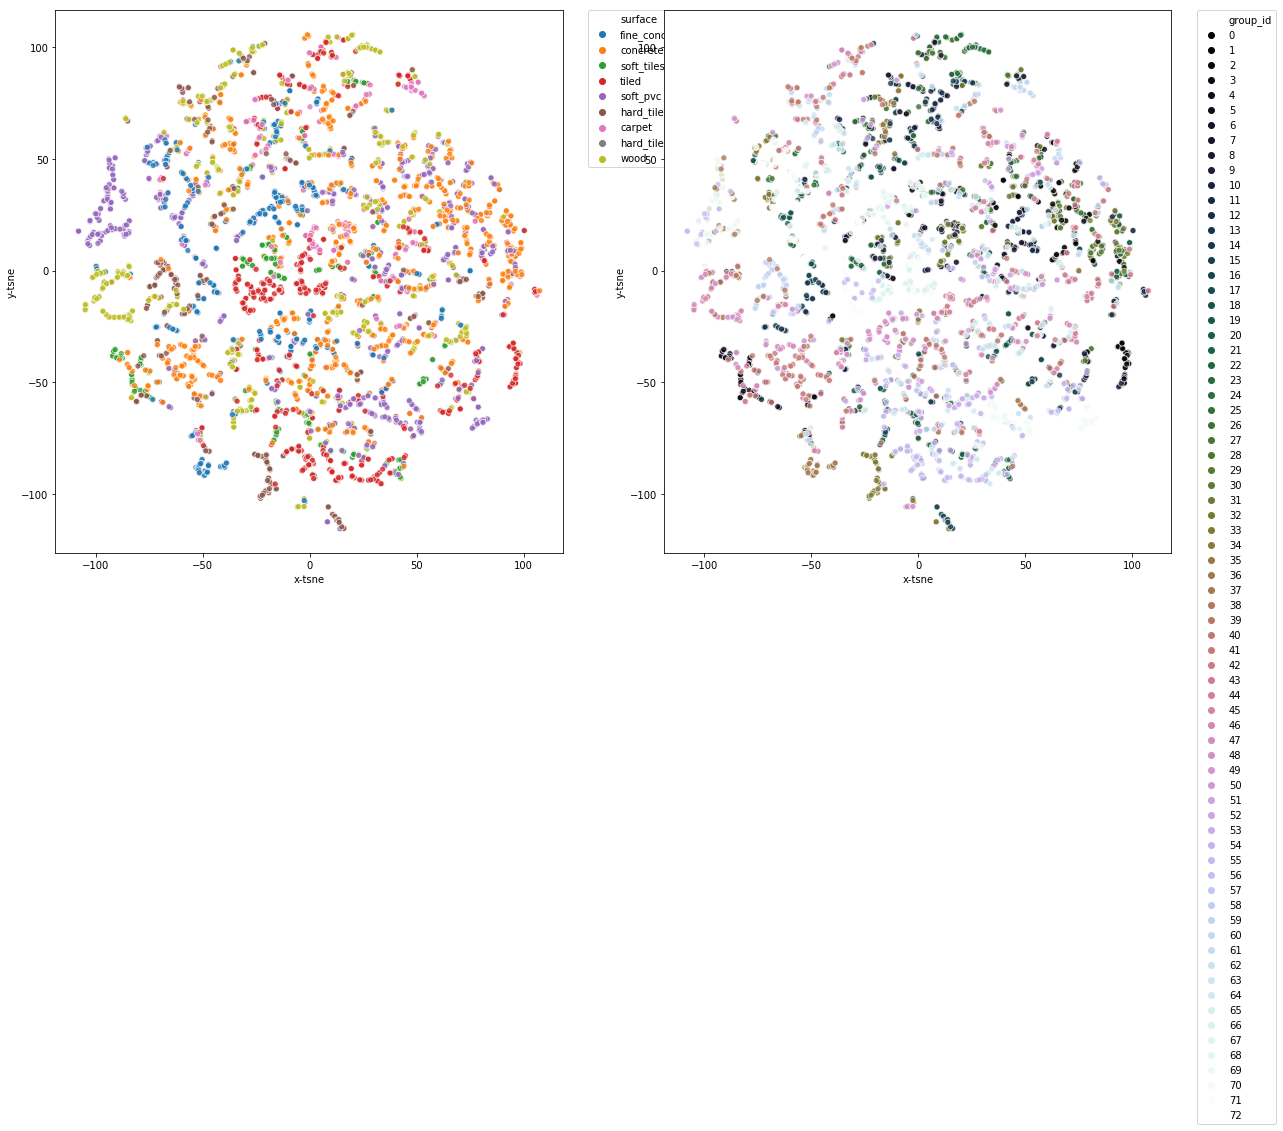

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.000s...
[t-SNE] Computed neighbors for 3810 samples in 0.400s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 0.059597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.580658
[t-SNE] KL divergence after 1000 iterations: 0.901851


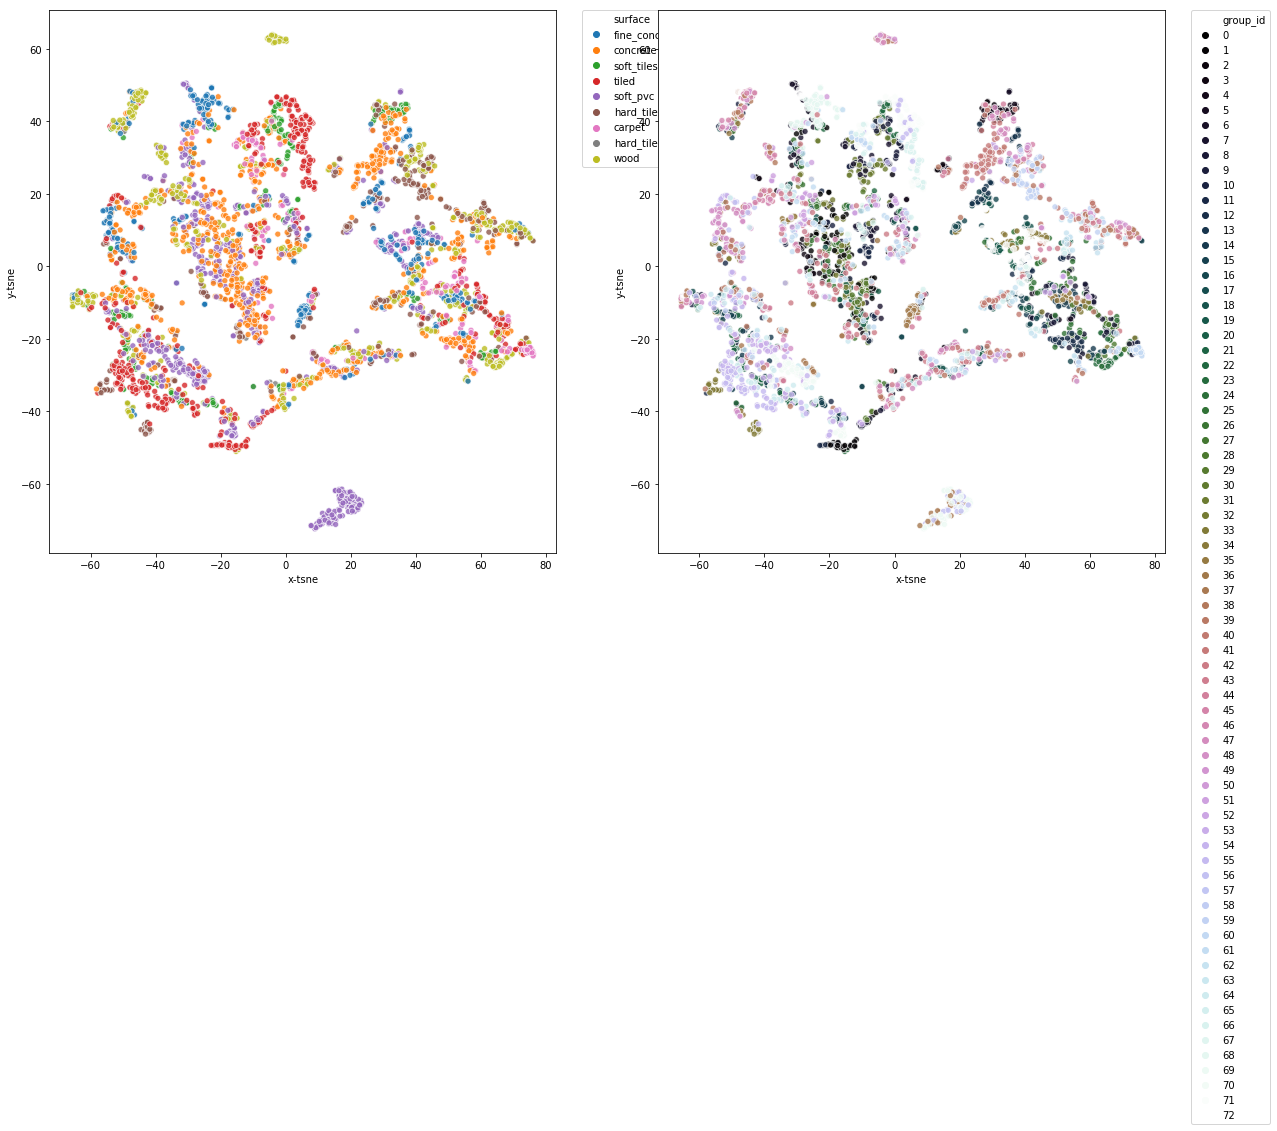

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.016s...
[t-SNE] Computed neighbors for 3810 samples in 0.528s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 0.069859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.365944
[t-SNE] KL divergence after 1000 iterations: 0.837309


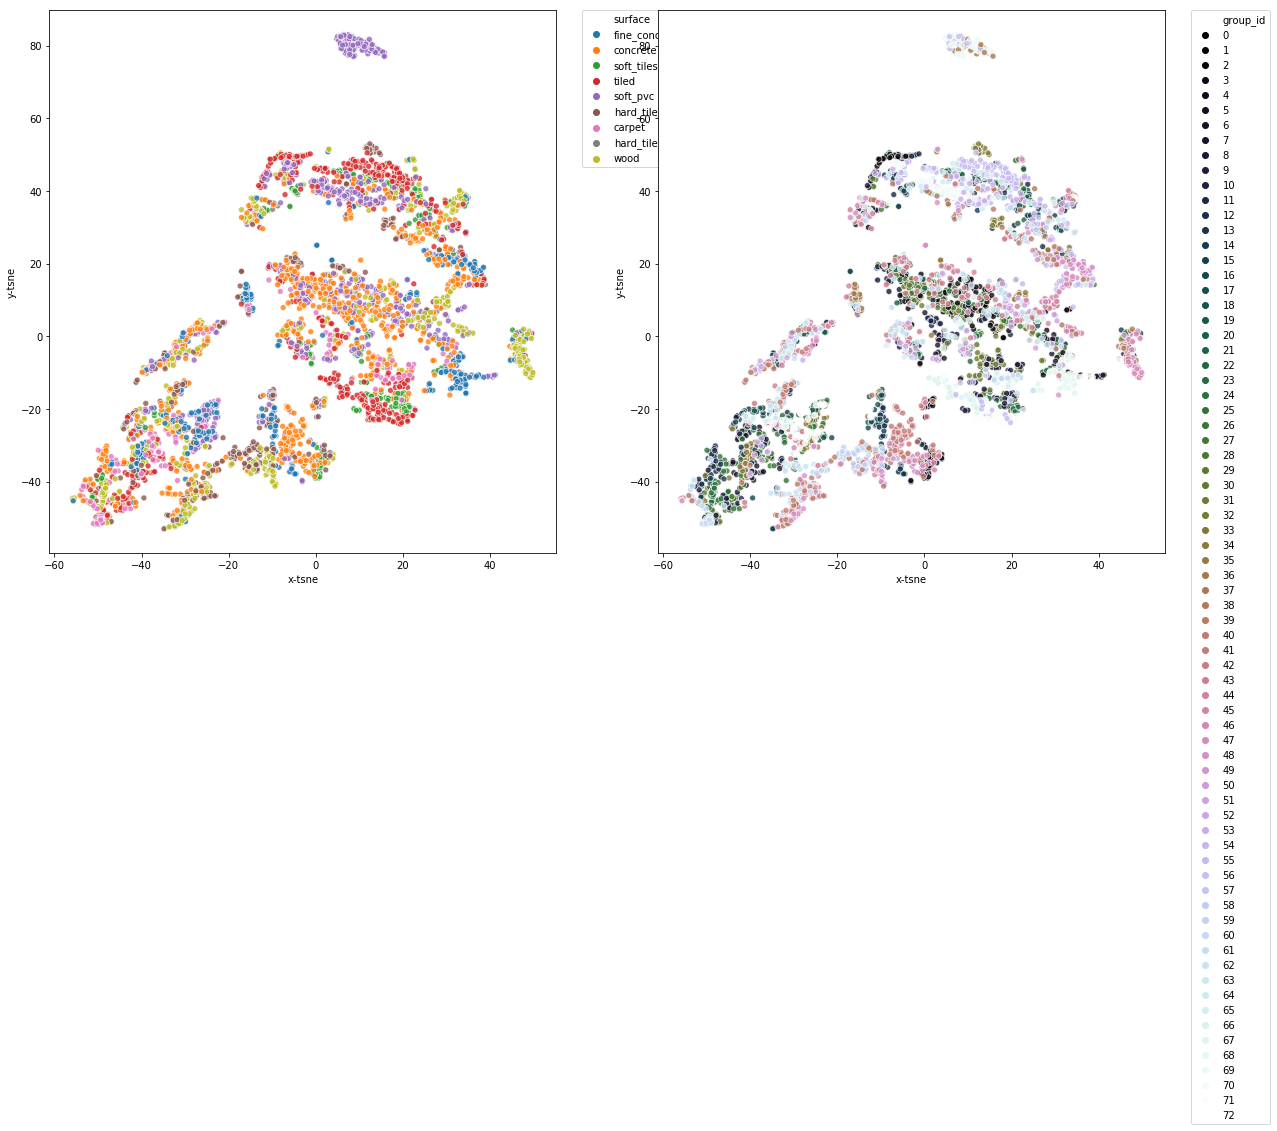

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.016s...
[t-SNE] Computed neighbors for 3810 samples in 0.725s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 0.087471
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.386772
[t-SNE] KL divergence after 1000 iterations: 0.702053


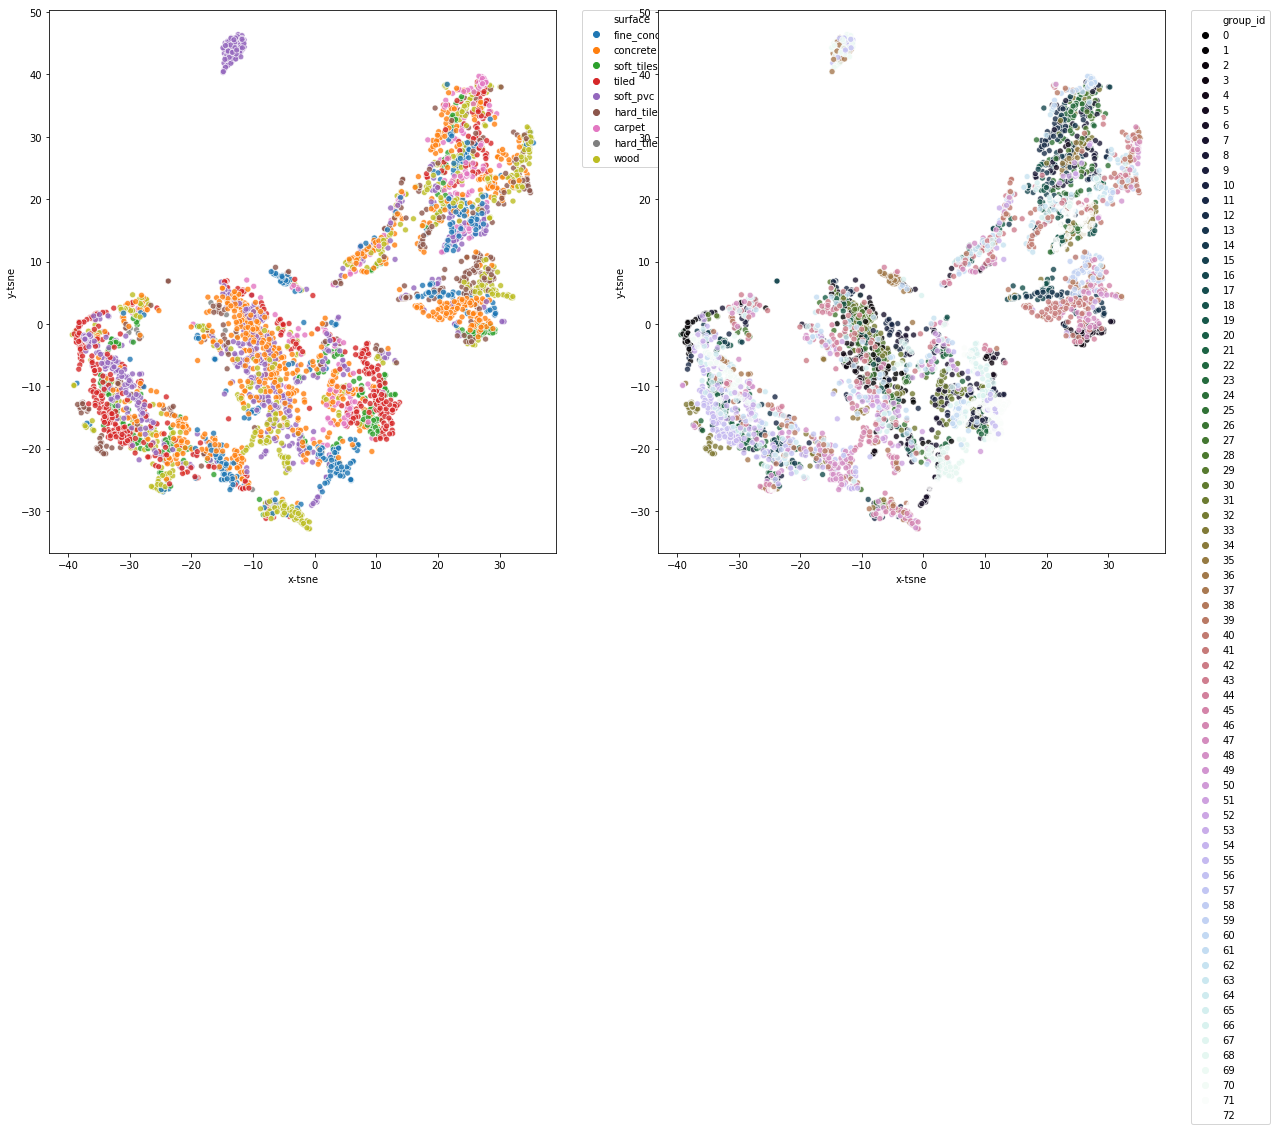

[t-SNE] Computing 451 nearest neighbors...
[t-SNE] Indexed 3810 samples in 0.000s...
[t-SNE] Computed neighbors for 3810 samples in 0.879s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3810
[t-SNE] Computed conditional probabilities for sample 2000 / 3810
[t-SNE] Computed conditional probabilities for sample 3000 / 3810
[t-SNE] Computed conditional probabilities for sample 3810 / 3810
[t-SNE] Mean sigma: 0.100844
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.705666
[t-SNE] KL divergence after 1000 iterations: 0.613193


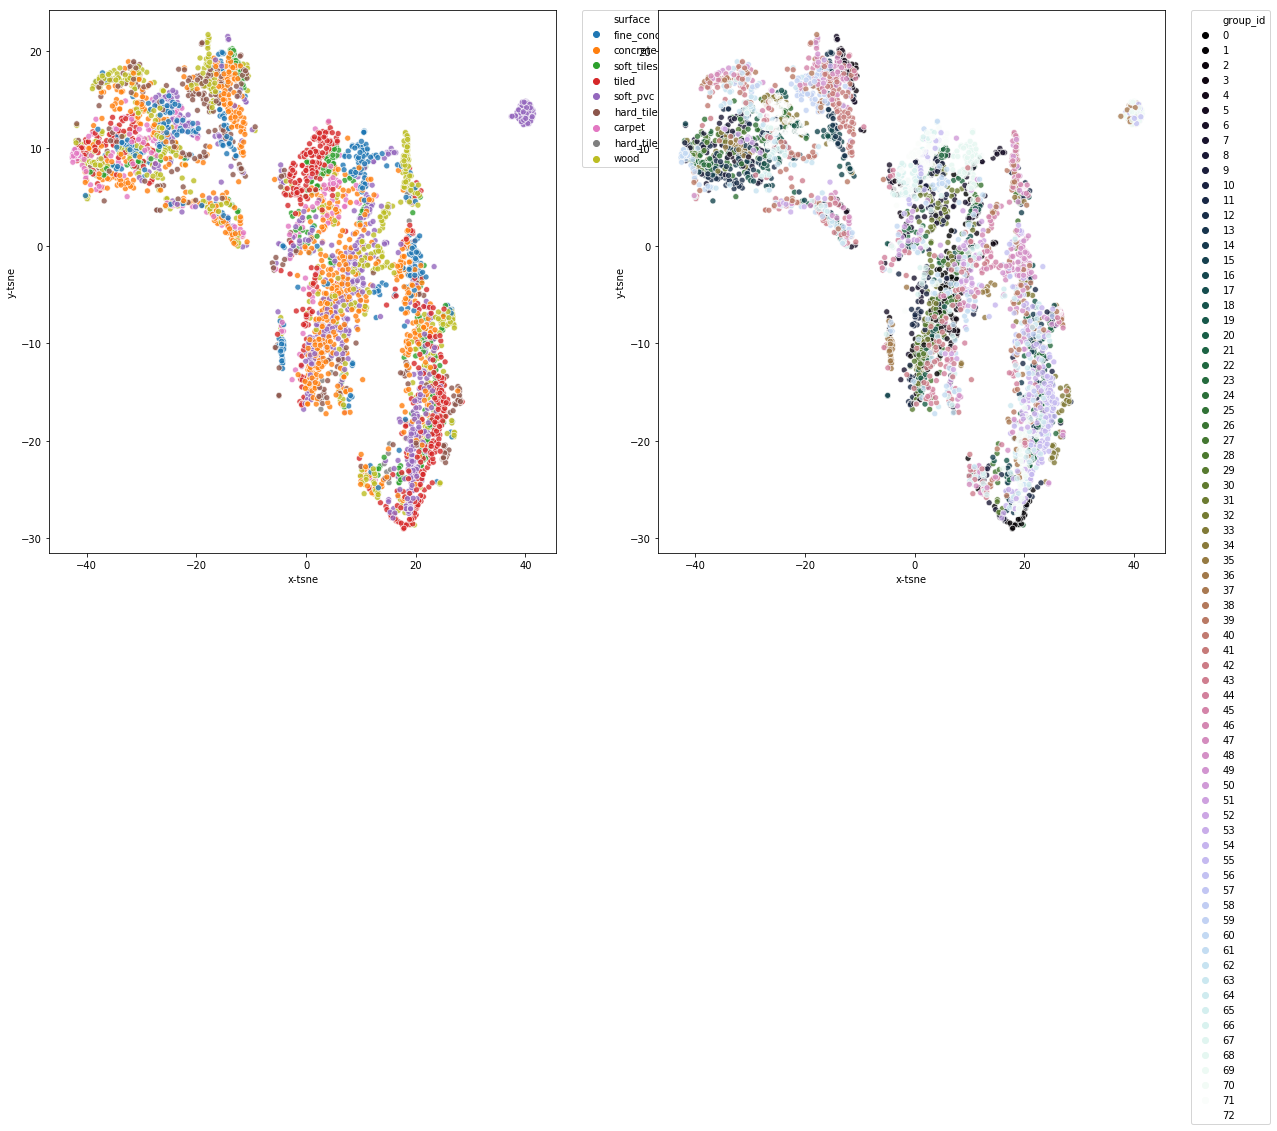

In [19]:
for perplexity in perplexity_list:
    t_sne_visualize(y, perplexity, 1000)